# Training the model

### Imports

In [1]:
import glob
import numpy as np

from pprint import pprint
from collections import deque

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Activation, concatenate
from keras.utils import np_utils, normalize, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import *


from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf

Using TensorFlow backend.


## Hyperparameters

In [2]:
SEQ_LEN = 3
FUTURE_SEQ_PREDICT = 1

## Prepare the data

### Function given an array, sequence length and prediction sequence length, returns an array with that structure for the network

In [3]:
def createXY(arr, sequenceLength, predictionLength):
    x = []
    y = []
    
    i = 0
    while i+sequenceLength+predictionLength < len(arr):
        x.append(arr[i : i+sequenceLength])
        y.append(arr[i+sequenceLength : i+sequenceLength+predictionLength])
        i += sequenceLength
        
    return (np.array(x), np.array(y))

In [4]:
def shuffle(arr):
    return np.random.shuffle(arr)

In [5]:
path = "./numpyRepresentation/"
noOfInputData = 100000
x = []
y = []

for file in glob.glob(f"{path}*.npy"):
    if len(x) >= noOfInputData:
        break
    
    x_data, y_data = createXY(np.load(file), 3, 1)
#     print(x_data.ndim)
    if x_data.ndim == 3:
        x += list(x_data)
        y += list(y_data)
    
x = to_categorical(x)
y = to_categorical(y)

In [6]:
# 80/20 split for training/testing dataset
trainLength = int(round((len(x) * 4)/5))
x_train = x[:trainLength]
x_test = x[trainLength:]
y_train = y[:trainLength]
y_test = y[trainLength:]

In [7]:
pprint(x_train[:,:,1,:].shape)

(1022, 3, 120)


In [58]:
# NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

from keras.utils import plot_model
from time import time


input_notes = Input(shape=(3,120), name="input_notes")
input_length = Input(shape=(3,120), name="input_length")
inputs = concatenate([input_notes, input_length])

model = LSTM(128, return_sequences=True)(inputs)
model = Dropout(0.2)(model)
model = LSTM(128, return_sequences=False)(model)
model = Dropout(0.2)(model)

output_note = Dense(114, activation="softmax", name='output_note')(model)
output_length = Dense(114, activation="softmax", name="output_length")(model)

model = Model(inputs=[input_notes, input_length], outputs=[output_note, output_length])
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])


# model = Sequential()
# model.add(LSTM(256, input_shape=x_train.shape[1:], return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(256, return_sequences=False))
# model.add(Dropout(0.2))
# # model.add(Dense(32))
# # model.add(Reshape((1, 128)))
# model.add(Dense(2, activation='softmax'))
# model.compile(
#     loss='categorical_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )
# model.summary()

# plot_model(model, to_file='model.png')

tensorboard = TensorBoard(log_dir="./logs/{}".format(time()), histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

filepath = "RNN_Final-{epoch:02d}"  # unique file name that will include the epoch and the validation acc for that epoch
# checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min',
)

# Train model
history = model.fit(
    {'input_notes': x_train[:,:,0,:], 'input_length': x_train[:,:,1,:]},
    {'output_note': y_train[:,0,0,:], 'output_length': y_train[:,0,1,:]},
    batch_size=32,
    epochs=100,
    validation_data=(
        [x_test[:,:,0,:], x_test[:,:,1,:]],
        [y_test[:,0,0,:], y_test[:,0,1,:]]),
    callbacks=[tensorboard, checkpoint, earlystopping]
)

Train on 1022 samples, validate on 255 samples
Epoch 1/100
1022/1022 [==============================] - 8s 8ms/step - loss: 8.4223 - output_note_loss: 4.4272 - output_length_loss: 3.9951 - output_note_acc: 0.1018 - output_length_acc: 0.4335 - val_loss: 5.1667 - val_output_note_loss: 3.2880 - val_output_length_loss: 1.8787 - val_output_note_acc: 0.1333 - val_output_length_acc: 0.5294
Epoch 2/100
1022/1022 [==============================] - 1s 1ms/step - loss: 5.0040 - output_note_loss: 3.1080 - output_length_loss: 1.8960 - output_note_acc: 0.1213 - output_length_acc: 0.3865 - val_loss: 4.4791 - val_output_note_loss: 2.9777 - val_output_length_loss: 1.5014 - val_output_note_acc: 0.0941 - val_output_length_acc: 0.5294
Epoch 3/100
1022/1022 [==============================] - 1s 1ms/step - loss: 4.5558 - output_note_loss: 2.9528 - output_length_loss: 1.6030 - output_note_acc: 0.1820 - output_length_acc: 0.4863 - val_loss: 4.4350 - val_output_note_loss: 2.9712 - val_output_length_loss: 1.463

In [59]:
# Score model
score = model.evaluate([x_test[:,:,0,:], x_test[:,:,1,:]], [y_test[:,0,0,:], y_test[:,0,1,:]], verbose=1)
i = 0
while i < len(model.metrics_names):
    print(f"{model.metrics_names[i]}:",score[i])
    i+=1
# Save model
model.save("models/model")

255/255 [==============================] - 0s 589us/step
loss: 3.4983808629653033
output_note_loss: 2.3422739767560774
output_length_loss: 1.1561068796644023
output_note_acc: 0.25490195996621073
output_length_acc: 0.6549019599662108


## Plot training and validation scores

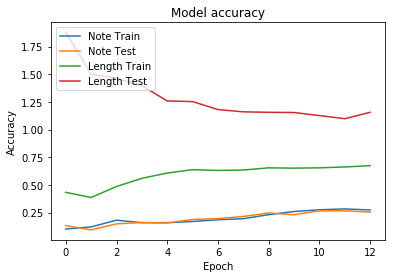

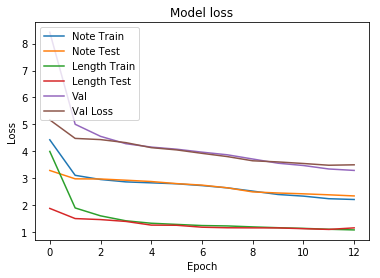

In [60]:
# plotting
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['output_note_acc'])
plt.plot(history.history['val_output_note_acc'])
plt.plot(history.history['output_length_acc'])
plt.plot(history.history['val_output_length_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Note Train', 'Note Test', 'Length Train', 'Length Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['output_note_loss'])
plt.plot(history.history['val_output_note_loss'])
plt.plot(history.history['output_length_loss'])
plt.plot(history.history['val_output_length_loss'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Note Train', 'Note Test', 'Length Train', 'Length Test', "Val", "Val Loss"], loc='upper left')
plt.show()

In [13]:
model = model.load("../../models/model-2")
data = np.load("./numpyRepresentation/Digimon - Butterfly (Piano Version)0.npy")
data = to_categorical(data)
data_notes = np.reshape(data[:,0,:], (63, 3 , 103))
data_length = np.reshape(data[:,1,:], (63, 3, 103))

NameError: name 'model' is not defined

In [11]:
prediction = model.predict([data_notes, data_length])
print(prediction)
# np.save("./prediction", np.reshape(prediction, (63,2)))

NameError: name 'model' is not defined

In [13]:
# pprint(prediction.reshape(63,2))
def generateNotes(model, sequence):
    return model.predict(sequence)

In [90]:
PREDICTION_LENGTH = 20

prediction = np.reshape(prediction, (63,2))

i = 0
input_sequence = np.array([prediction[:SEQ_LEN]])
output_sequence = input_sequence.copy()
# print(input_sequence)
while i < PREDICTION_LENGTH:
    generated_notes = generateNotes(model, input_sequence)
    output_sequence = np.append(output_sequence, generated_notes, axis=1)
    input_sequence = np.append(input_sequence, generated_notes, axis=1)
    input_sequence = np.delete(input_sequence, 0, 1)
    i+=1

In [14]:
from keras.utils import to_categorical

arr1 = np.array([[[1, 6], [2, 7 ],[3, 8]]])
arr2 = np.array([[[0.34858927,0.6514107 ]]])

# print("Shape: ", arr1.shape, arr2.shape)

pprint(to_categorical(arr1))
result = np.append(arr1,arr2, axis=1)
# pprint(result)
# np.delete(result, 0, 1)

array([[[[0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.]]]], dtype=float32)


In [109]:
testArr = [[[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0], [0,0,0,0,0,1,0,0,0,0,0,0,0,]],
          [[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0], [0,0,0,0,0,1,0,0,0,0,0,0,0,]]]
np.array(testArr, dtype=np.float32)

ValueError: setting an array element with a sequence.